# Data Loading
Data was downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96058, unzipped and stored in the data folder. 
The raw dataset is named "em" and its path can be found in the analysis .env file.

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 


em = pd.read_csv(os.getenv("EM"), index_col=0)

In [25]:
em.shape

(30865, 3409)

Traditionally, gene expression matrix data is in the format that each row is a gene and each column is a sample (because it's the default for most microarray, RNA-seq, and general bioinformatics data formats).  
I am however transposing the dataset, for two reasons:
1. I will be performing machine learning later on, which will require this input format (e.g. scikit-learn).
2. I am more familiar with this format.

In [26]:
em_T = em.T
print(f"Initial shape (samples x genes): {em_T.shape}")

Initial shape (samples x genes): (3409, 30865)


## Initial Overlook
For the very first outlook over the data, a plot to see the distribution of the values

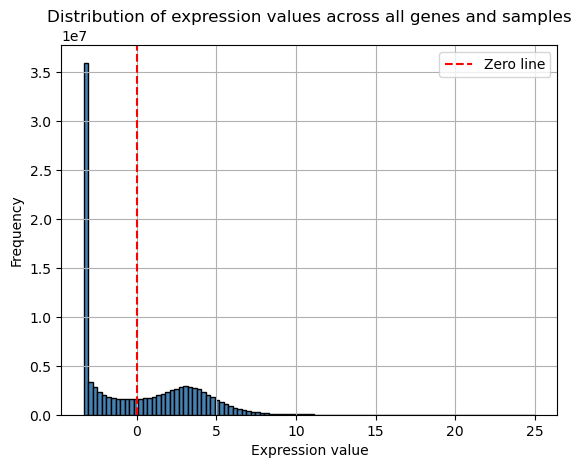

In [34]:
all_values = em.values.flatten()

# Plot a histogram
plt.hist(all_values, bins=100, color='steelblue', edgecolor='black')
plt.xlabel("Expression value")
plt.ylabel("Frequency")
plt.title("Distribution of expression values across all genes and samples")
plt.grid(True)
plt.axvline(x=0, color='red', linestyle='--', label='Zero line')
plt.legend()
plt.show()

Interesting:
- we see that there is a spike
- the spike is NOT at zero as we might expect
- there are negative values


Spike around -3: wondering where this value came from, could be a placeholder for no expression.

Edit: 
The paper on the preprocessing of the dataset (https://pubmed.ncbi.nlm.nih.gov/32913985/) mentions:
"Gene expression data were pre-processed by collapsing on 27,979 unique gene symbols (sum of FPKM values of each matching transcript), adding to each gene’s expression measurement 0.1 FPKM, performing a log2 transformation, and centering the gene expression values by subtracting the row-wise (gene) median (calculated across the 49 primary data sets) from the values in each row of data."

-> That would mean all rows with -3.219 have no expression. (because it is log(0+0.1)).

BUT:
- distribution is still right-skewed and not centered at zero -> no median zentering was applied yet?!

## Constant Columns
In the preview, I noticed that there are columns that only contained one unique value in the whole dataset, so I deleted these columns to save computational time and power.

Since it is unlikely that a column is constant for expression other than 0 expression, likely all columns that are constant are columns of gnees that are not being expressed at all, so I identify this.

In [28]:
constant_cols = em_T.columns[em_T.nunique() <= 1]
print(f"Number of constant columns: {len(constant_cols)}")
if len(constant_cols) > 0:
    print("Example constant columns:", constant_cols[:5].tolist())

if len(constant_cols) > 0:
    print("Constant columns and their unique value:")
    for col in constant_cols[:5]:
        unique_val = em_T[col].unique()
        print(f"{col}: {unique_val}")

Number of constant columns: 2236
Example constant columns: ['AB167336', 'AB209638', 'AB240007', 'AB240039', 'AB360851']
Constant columns and their unique value:
AB167336: [-3.32192809]
AB209638: [-3.32192809]
AB240007: [-3.32192809]
AB240039: [-3.32192809]
AB360851: [-3.32192809]


## Low expression Columns
The next step is to analyse whether we have columns that have low expression, they would not add to the value and cost computational time.

Number of low-expression columns: 4715
Example low-expression columns: ['6M1-18', '7M1-2', 'AA06', 'AB052595', 'AB107049']


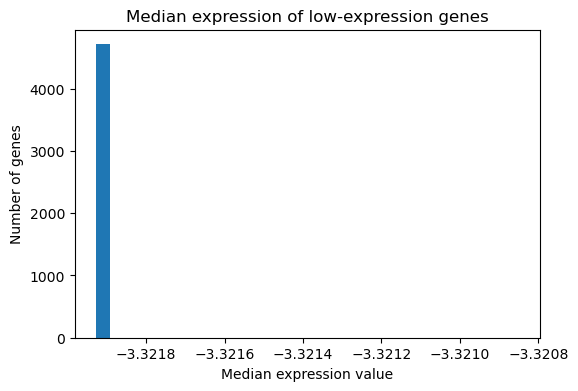

In [29]:
import numpy as np
pseudo_zero = np.log2(0.1)  # This is the value used in the dataset for no expression
tolerance = 1e-2
min_samples = int(0.01 * em_T.shape[0])

# Count how many samples have expression different from pseudo_zero
expressed = (np.abs(em_T - pseudo_zero) > tolerance).sum(axis=0)
low_expression_cols = expressed[expressed < min_samples].index
print(f"Number of low-expression columns: {len(low_expression_cols)}")
if len(low_expression_cols) > 0:
    print("Example low-expression columns:", low_expression_cols[:5].tolist())

medians = em_T[low_expression_cols].median(axis=0)
plt.figure(figsize=(6,4))
plt.hist(medians, bins=30)
plt.xlabel("Median expression value")
plt.ylabel("Number of genes")
plt.title("Median expression of low-expression genes")
plt.show()

In [30]:
n_cols_before = em_T.shape[1]

print(f"Number of columns before dropping constant and low expression columns: {n_cols_before}")

# Drop constant columns
cleaned_em_T = em_T.drop(columns=constant_cols)
print(f"Dropped {len(constant_cols)} constant columns.")


remaining_low_expression_cols = [col for col in low_expression_cols if col in cleaned_em_T.columns]

filtered_em_T = cleaned_em_T.drop(columns=remaining_low_expression_cols)
print(f"Dropped {len(remaining_low_expression_cols)} low-expression columns.")

print(f"Number of columns after dropping constant & low-expression columns: {filtered_em_T.shape[1]}")

Number of columns before dropping constant and low expression columns: 30865
Dropped 2236 constant columns.
Dropped 2479 low-expression columns.
Number of columns after dropping constant & low-expression columns: 26150


## NA-Check

In [31]:
na_cols = filtered_em_T.isna().sum()
na_cols = na_cols[na_cols > 0]
print(na_cols)


Series([], dtype: int64)


There are no NA values to take care of.

## Exporting the Filtered Dataset
I want to export the current state of the dataset as "filltered", meaning that no other preprocessing besides removal of constant and low-expression columns.

In [32]:
filtered_em_T.to_csv(os.getenv("FILTERED"), float_format='%.20f')
print(f"Filtered dataset saved to {os.getenv('FILTERED')}") 

Filtered dataset saved to /Users/sarah/Code/bioinformatics-tool/backend/data/GSE96058_filtered.csv


Applying median-centering per column.

In [55]:
median_centered = filtered_em_T.sub(filtered_em_T.median(axis=0), axis=1)

# After calculating median_centered
median_centered = filtered_em_T.sub(filtered_em_T.median(axis=0), axis=1)

# Check for infinite values and replace them with NaN before saving
inf_count_median = np.isinf(median_centered.values).sum()
if inf_count_median > 0:
    print(f"ATTENTION: {inf_count_median} infinite values found in median_centered DataFrame. Replacing with NaN.")
    median_centered.replace([np.inf, -np.inf], np.nan, inplace=True)

Applying z-scoring per column.

In [56]:
# Drop columns with zero std dev after median-centering
stds = median_centered.std(axis=0, ddof=0)
zero_std_cols = stds[stds == 0].index

print(f"Dropping {len(zero_std_cols)} columns with zero standard deviation after centering.")

median_centered = median_centered.drop(columns=zero_std_cols)


Dropping 2 columns with zero standard deviation after centering.


In [57]:
# Shows columns with any NaNs and how many there are
na_cols = median_centered.isna().sum()
na_cols = na_cols[na_cols > 0]
print(na_cols)


Series([], dtype: int64)


In [58]:
print(np.isinf(median_centered.values).sum())  # total count
print((~np.isfinite(median_centered)).sum())   # includes inf, -inf, NaN

0
5_8S_rRNA    0
5S_rRNA      0
7SK          0
A1BG         0
A1BG-AS1     0
            ..
ZYG11A       0
ZYG11B       0
ZYX          0
ZZEF1        0
ZZZ3         0
Length: 26148, dtype: int64


In [59]:
median_centered.replace([np.inf, -np.inf], np.nan, inplace=True)
print("After replacing inf/-inf, NaNs per column:")
print(median_centered.isna().sum()[lambda x: x > 0])


After replacing inf/-inf, NaNs per column:
Series([], dtype: int64)


In [61]:
median_centered.shape

(3409, 26148)

In [ ]:
median_centered.to_csv(os.getenv("MEDIAN_CENTERED"), float_format='%.20f')

In [ ]:
zscored = median_centered.sub(median_centered.mean(axis=0), axis=1)
zscored = zscored.div(median_centered.std(axis=0, ddof=0), axis=1)

inf_count_zscored = np.isinf(zscored.values).sum()
if inf_count_zscored > 0:
    print(f"ATTENTION: {inf_count_zscored} infinite values found in zscored DataFrame. Replacing with NaN.")
    zscored.replace([np.inf, -np.inf], np.nan, inplace=True)


In [40]:
# Shows columns with any NaNs and how many there are
na_cols = zscored.isna().sum()
na_cols = na_cols[na_cols > 0]
print(na_cols)


Series([], dtype: int64)


In [ ]:
zscored.to_csv(os.getenv("ZSCORED"), float_format='%.20f')